## Analiza dokładności i czasu uczenia dla Big Data - porównanie metody gradientu prostego, metody gradientu stochastycznego i zmniejszenia zbioru uczącego.

Imię, nazwisko: Krzysztof Jarek.

Kierunek, semestr: IT II, 2.

Data oddania: 24.01.2023.

<center><img src='pictures/comparison.png' width=700 height=500 /></center>

## Cele:

* implementacja algorytmów realizujących metody Gradient Descent (GD) i Stochastic Gradient Descent (SGD),
* wykorzystanie pierwszego algorytmu również dla przebadania zagadnienia związanego z *undersampling'iem*,
* przeprowadzenie analizy porównawczej działania implementacji ze względu na czas wykonania i dokładność.

### Problem:

**Metoda gradientu prostego** (też metoda najszybszego spadku, ang. Gradient Descent) sprowadza się do koncepcji iteracyjnego algorytmu optymalizacji pierwszego rzędu, służącego do znajdowania lokalnego minimum funkcji różniczkowalnej. Upraszczając, głowna idea algorytmu sprowadza się do tego, aby powtarzane były kroki w kierunku przeciwnym do gradientu (lub przybliżonego gradientu) funkcji w bieżącym punkcie, ponieważ jest to kierunek tzw. najszybszego spadku, w efekcie czego iteracyjnie przybliżane będzie ekstremum funkcji.

Algorytm, czy też wersje będące jego bliższym lub dalszym rozwininięciem, są obecnie powszechnie stosowane w ramach  badań uczenia maszynowego (ML). Wśród rozwiązań opracowanych w ostatniej wyróżniały się te których zbudowanie wiązało się z dodatkowym wykorzystaniem metod stochatycznych.

Nawiązując do tej problematyki, w podejmowanym badaniu bazowy algorytm został poddany porównaniu dwóm wybranym wersjom zmodyfikowanym pod względem wydajności i precyzji: jednej dodatkowo implementującej próbkowanie stochatyczne, drugiej wykorzystującej *undersampling*.

## Przebieg badania:

### Wykorzystany oprogramowanie, sprzęt:
* MacOs 10.15 Catalina,
* środowisko: Jupyter Notebook,
* procesor: 2,7 GHz Dwurdzeniowy procesor Intel Core i5,
* pamięć: 8 GB 1867 MHz DDR3.

### Prezentacja zbioru i danych w nim zawartych:

Podstawowe dane opisujące zbiór danych:
* tytuł: "**SPAM E-mail Database**",
* twórcy, adres: Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt, Hewlett-Packard Labs, 1501 Page Mill Rd., Palo Alto, CA 94304,
* donator: George Forman (gforman at nospam hpl.hp.com),
* zdefiniowane zadanie: ang. Determine whether a given email is spam or not.
* w zbiorze ~7% to błąd błędnej klasyfikacji,
* "False positives (marking good mail as spam) are very undesirable. If we insist on zero false positives in the training/testing set, 20-25% of the spam passed through the filter.",
* "Koncepcja „spamu” jest zróżnicowana: reklamy produktów/stron internetowych, programy szybkiego zarabiania pieniędzy, łańcuszki, pornografia...",
* liczba instancji w zbiorze: **4601** (1813 to spam = 39,4%),
* liczba atrybutów: **58** (57 ciągłych, 1 etykieta klasy nominalnej),
* zbiór dostępny m.in. na https://archive.ics.uci.edu/ml/datasets/spambase.

Na podstawie powyższego opisu danych można zauważyć, że badany problem jaki wynika z charakteru wybranego zbioru będzie problemem klasyfikacji: czy dany zestaw liczb reprezetnuje spam czy nie? Z tego powodu problem będzie można rozwiązywać w oparciu o wykorystanie funkcji regresji logistycznej przyjętej jako funkcja celu *f*.

Zanim jednak przystąpiło się do implementacji samych algorytmów, najpierw należało poddać dane koniecznym przekształceniom tak by mogły pozwalać na łatwiejsze, bardziej efektywne przeprowadzanie procesów obliczeniowych związanych z uruchamianiem kolejnych metod.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics

plt.style.use('seaborn')
WEIGHT, HEIGHT = 7, 10

In [2]:
spam_df = pd.read_csv('data/spam.data', header=None, sep=' ')

In [3]:
print( 'Rozmiar zbioru:', spam_df.shape )

Rozmiar zbioru: (4601, 58)


Prezentacja podstawowych charakterystyk statystycznych danych ze zbioru (dla możliwości wglądu):

In [4]:
spam_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


In [5]:
spam_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


Na samym końcu tegeo etapu przetwarzania danych ze zbioru zostały wydzielone zbiory *X* i *y*, i pierwszy z nich został poddany standaryzacji:

In [6]:
X = spam_df.iloc[:, :-1].values
y = spam_df.iloc[:, -1].values

In [7]:
print( 'Rozmiar zbiorów X i y:', X.shape, 'i', y.shape, '.' )
print( 'Typ danych dla zbiorów X i y:', X.dtype, 'i', y.dtype, '.' )

Rozmiar zbiorów X i y: (4601, 57) i (4601,) .
Typ danych dla zbiorów X i y: float64 i int64 .


In [8]:
X_norm = np.copy(X)
X_mean, X_std = X_norm.mean(), X_norm.std()
X_norm = ( X_norm - X_mean ) / X_std

### Przygotowane funkcje:

W celu realizacji przygotowania algorytmów i przeprowadzenia badania z ich wykorzystaniem, konieczne było uprzednie zaimplementowanie funkcji mogących pozwolić na przeprowadzanie procesu numerycznego interferowania służacego konstruowaniu systemu decyzyjnego.  
Jako fukcja aktywacji została wybrana fukcja sigmoidalna (*sigmoid*, $h_{\theta}$), definiowana tu wzorem *g(z)*:  
<img align="left" src='pictures/sigmoid.png' width=400 height=700 />  
<br></br><br></br><br></br>  
, gdzie $x$ to macierz próbek, a ${\theta}$ to wektor wag.

In [9]:
def sigmoid(z):  
    return np.exp(-np.logaddexp(1e-16, -z))

Funkcja kosztu (celu) została zdefiniowana poprzez następujące równanie, którego idea opiera się o koncepcję regresji logistycznej:  
<img align="left" src='pictures/cost_function.png' width=500 height=800 />  
<br></br><br></br><br></br>  
, gdzie $y$ to wektor rozwiązań, inaczej poprawnych odpowiedzi.

In [10]:
def CostFunction(X, y, theta):
    
    m = y.shape[0];
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    
    J  = - ( y.T.dot( np.log(h_theta) ) + (1 - y).T.dot( np.log(1-h_theta) ) ) /m
    diff = (h_theta - y) /m # dJ0
    dJ = (diff).T.dot(X) /m
    
    return J, diff, dJ

Poza tymi funkcjami i ich powyższymi implementacjami, napisane zostały funkcje mogące pełnić funkcję pomocniczą, jak wizualizacja danych, czy też pozwolić na policzenie istoatnych parametrów jak *accuracy* (dokładność) lub przeprowadzenie predykcji dla zbioru:

In [11]:
def predict(X, theta):
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    return np.where(h_theta >= 0.5, 1, 0)

In [12]:
def get_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.shape[0]

In [13]:
def plot_confusion_matrix(y_test, predicts, acc):
    print('Tablica pomyłek dla metody:')
    cm = metrics.confusion_matrix(y_test, predicts)
    sn.heatmap(cm, annot=True, cmap="crest")
    plt.ylabel('Aktualne klasy', size=15)
    plt.xlabel('Predykowane klasy', size=15)
    plt.title(f'Accuracy: {acc*100:.2f}%', size=15)
    plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
    plt.show()

### Gradient Descent:

Następnym krokiem było bezpośrednie zaimplementowanie funkcji realizującej liczenie gradientu prostego. Implementacja tego algorytmu została przeprowadzona w oparciu o niżej zdefiniowane wzory.  
Uproszczony zapis formalny dla uakualnienia wartośći $\theta_{j}$ i samej metody GD:  
<img align="left" src='pictures/gradient_descent.png' width=200 height=400 />  
<br></br><br></br>
<img align="left" src='pictures/pseudocode.png' width=500 height=700 />

In [14]:
def GradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

Dla przeprowadzanych symulacji zostały przyjęte następujące parametry- w tym *STOCH_FRACTION* dla SGD równe 0.33 i *SAMPLING_FRACTION* dla problemu *undersampling'u* równe 0.5:

In [15]:
ALPHA = 0.005
NUM_ITER = 1200
STOCH_FRACTION = 0.33
SAMPLING_FRACTION = 0.5

In [16]:
m, n  = X_norm.shape
theta = np.random.rand(n+1)

Mając wszystko już przygotowane przeprowadzono symulacje działania algorytmu:

In [17]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface\'u:' )
time_GD = %timeit -r 3 -n 10 -o GradientDescent(X_norm, y, theta, ALPHA, NUM_ITER)

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface'u:
785 ms ± 150 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [18]:
thetaOpt, JOpt = GradientDescent(X_norm, y, theta, ALPHA, NUM_ITER)

In [19]:
print( 'Znalezione minimum:', JOpt )

Znalezione minimum: 0.9737949240920775


In [20]:
y_pred_GD = predict(X_norm, thetaOpt)

In [21]:
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Policzona accuracy (dokładność): {accuracy_GD:.6f}' )

Policzona accuracy (dokładność): 0.696153


Tablica pomyłek dla metody:


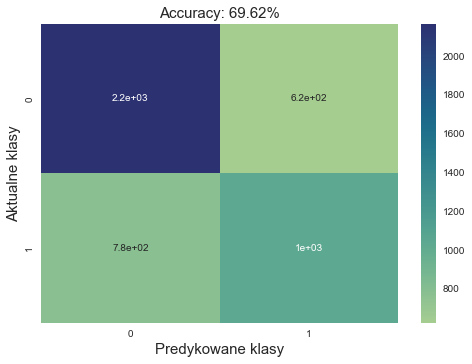

In [22]:
plot_confusion_matrix(y, y_pred_GD, accuracy_GD)

### Stochastic Gradient Descent:

Następnie zaimplementowany został algorytm Stochastic Gradient Descent, który od poprzedniego różni się jedynie jednym zmianionym elementem: otóż w każdej iteracji ze zbioru uczącego wybierany jest podzbiór losowych, unikatowych elementów, który następnie jest wykorzystywany w celu oblicznia wartości w tym kroku. Implementacja poniżej:

In [23]:
def StochasticGradientDescent( X, y, in_theta, alpha=0.1, num_iter=50, stoch_fraction=0.5 ):
    theta = in_theta.copy()
    X_len = X.shape[0]
    num_of_samples = int( X_len*stoch_fraction )
    
    for _ in range(num_iter):
        idx = np.random.choice( X_len, size=num_of_samples, replace=False )
        J, dJ0, dJ = CostFunction( X[idx,:], y[idx], theta )
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

Mając wszystko już przygotowane przeprowadzono symulacje działania algorytmu:

In [24]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface\'u:' )
time_SGD = %timeit -r 3 -n 10 -o StochasticGradientDescent(X_norm, y, theta, ALPHA, NUM_ITER, STOCH_FRACTION)

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface'u:
1.2 s ± 246 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [25]:
thetaOptSGD, JOptSGD = StochasticGradientDescent(X_norm, y, theta, ALPHA, NUM_ITER, STOCH_FRACTION)

In [26]:
print( 'Znalezione minimum:', JOptSGD )

Znalezione minimum: 0.9220572703856043


In [27]:
y_pred_SGD = predict(X_norm, thetaOptSGD)

In [28]:
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Policzona accuracy (dokładność): {accuracy_SGD:.6f}' )

Policzona accuracy (dokładność): 0.696153


Tablica pomyłek dla metody:


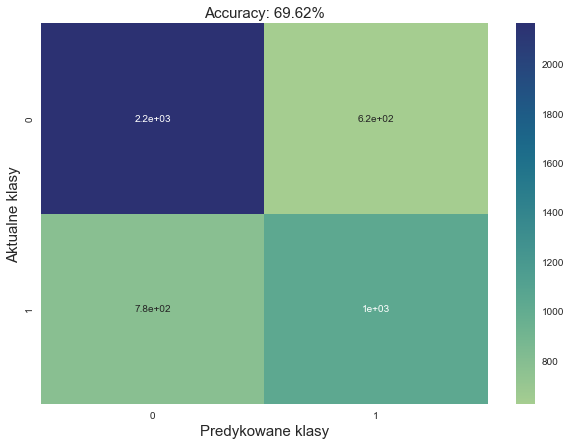

In [29]:
plot_confusion_matrix(y, y_pred_SGD, accuracy_SGD)

### Zastosowanie sampling'u:

*Undersampling* w analizie danych to techniki stosowane w celu dostosowania rozkładu klas w zbiorze danych (stosunku między różnymi reprezentowanymi klasami/kategoriami) lub też po prostu redukcji ilości danych, np. w celu przypsieszenia obliczeń, w pewnych przypadkach zmniejszenia redundancji.  
W kolejnych podejściu została zastosowana właśnie ta technika, dla celu zaimplementowania jakiej po prostu przeprowadzono uruchomienie algorytmu GD, który przeprowadził symulację dla odpowiednio zredukowawnego zbioru danych:

In [30]:
NUM_SAMPLES = int( m*SAMPLING_FRACTION )
idx_sampled = np.random.choice( m, size=NUM_SAMPLES, replace=False )

# check that each item occurs only once
print( "Czy próbki w nowym zbiorze powtarzają się:", ( np.bincount(idx_sampled.ravel()) == 1 ).all() )

Czy próbki w nowym zbiorze powtarzają się: False


In [31]:
X_sampled, y_sampled = X_norm[idx_sampled,:], y[idx_sampled]

Mając wszystko już przygotowane przeprowadzono symulacje działania algorytmu:

In [32]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface\'u:' )
time_Sampl = %timeit -r 3 -n 10 -o GradientDescent(X_sampled, y_sampled, theta, ALPHA, NUM_ITER)

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o funkcję inteface'u:
538 ms ± 69.2 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [33]:
thetaOptSampl, JOptSampl = GradientDescent(X_sampled, y_sampled, theta, ALPHA, NUM_ITER)

In [34]:
print( 'Znalezione minimum:', JOptSampl )

Znalezione minimum: 1.0025533275871947


In [35]:
y_pred_Sampl = predict(X_norm, thetaOptSampl)

In [36]:
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Policzona accuracy (dokładność): {accuracy_Sampl:.6f}' )

Policzona accuracy (dokładność): 0.695718


Tablica pomyłek dla metody:


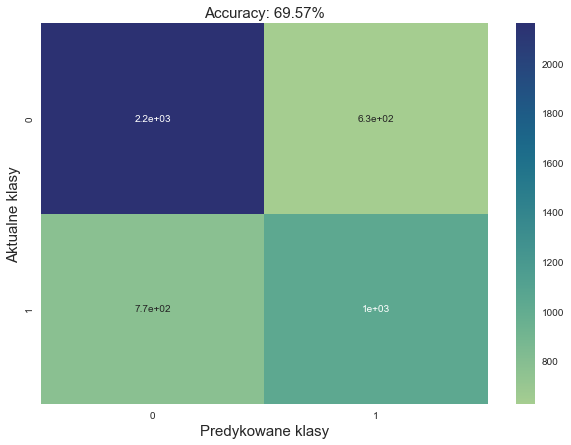

In [37]:
plot_confusion_matrix(y, y_pred_Sampl, accuracy_Sampl)

### Analiza przeprowadzonych symulacji:

W dalszej części przeprowadzono kolejne badania w celu pozyskania danych dla wizualizacji danych i ogólnych charaktarestyk procesów związanych z wydajnością zaimplementowanych algorytmów.  
Poniżej zamieszczono zmienione wersje funkcji *GradientDescent* i *StochasticGradientDescent*, napisanych dla celu zebrania danych koniecznych dla stworzenia odpowiednich wykresów. Oprócz nich zaimplementowano funkcje odpowiedzialne za generowanie wykresów.

In [38]:
def AnalyzeGradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    J_list = []
    theta_list = []
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
        J_list.append(J)
        theta_list.append(theta)
        
    return np.array(theta_list), np.array(J_list)

In [39]:
def AnalyzeStochasticGradientDescent( X, y, in_theta, alpha=0.1, num_iter=50, stoch_fraction=0.5 ):
    theta = in_theta.copy()
    X_len = X.shape[0]
    num_of_samples = int( X_len*stoch_fraction )
    
    J_list = []
    theta_list = []
    
    for _ in range(num_iter):
        idx = np.random.choice( X_len, size=num_of_samples, replace=False )
        J, dJ0, dJ = CostFunction( X[idx,:], y[idx], theta )
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
        J_list.append(J)
        theta_list.append(theta)
        
    return np.array(theta_list), np.array(J_list)

In [40]:
def plot_cost_function(J_list, title):
    plt.plot(range(1, len(J_list) + 1), J_list)
    plt.xlabel('Liczba iteracji', size=15)
    plt.ylabel('Wartość funkcja kosztu', size=15)
    plt.title(title, size=15)
    plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
    plt.show()

Poniżej wygenerowano wykresy zależności wartości funkcja kosztu od liczby iteracji dla poszczególnych algorytmów:

In [41]:
thetaOpt_list, JOpt_list = AnalyzeGradientDescent(X_norm, y, theta, ALPHA, NUM_ITER)

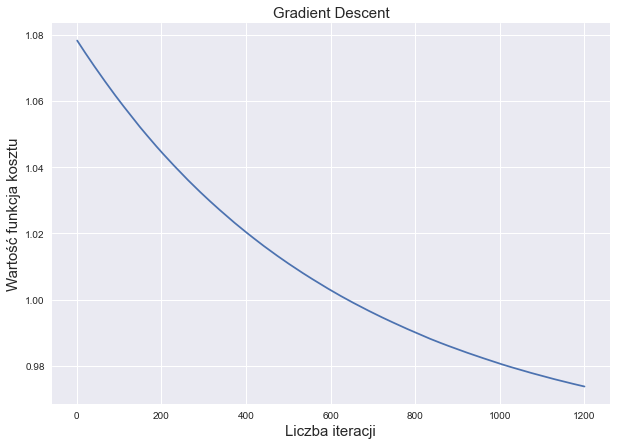

In [42]:
plot_cost_function(JOpt_list, 'Gradient Descent')

In [43]:
thetaOptSGD_list, JOptSGD_list = AnalyzeStochasticGradientDescent(
                            X_norm, y, theta, ALPHA, NUM_ITER, STOCH_FRACTION
                        )

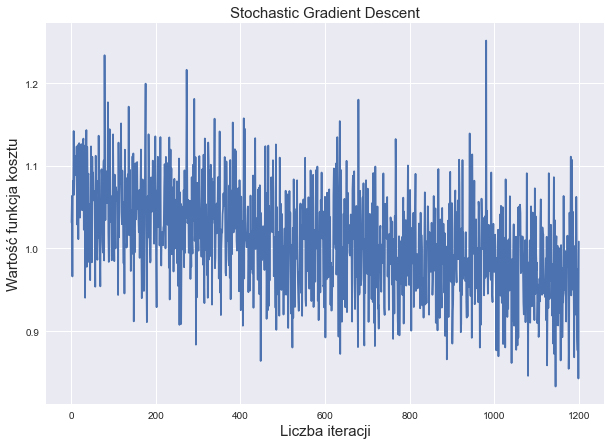

In [44]:
plot_cost_function(JOptSGD_list, 'Stochastic Gradient Descent')

Dla SGD obserwowalne są ciągłe dynamiczne zmiany wartości funkcja kosztu, co jest skutkiem stochatycznego charaktery dodanych zmian do tego tego algorytmu względem GD.

In [45]:
thetaOptSampl_list, JOptSampl_list = AnalyzeGradientDescent(X_sampled, y_sampled, theta, ALPHA, NUM_ITER)

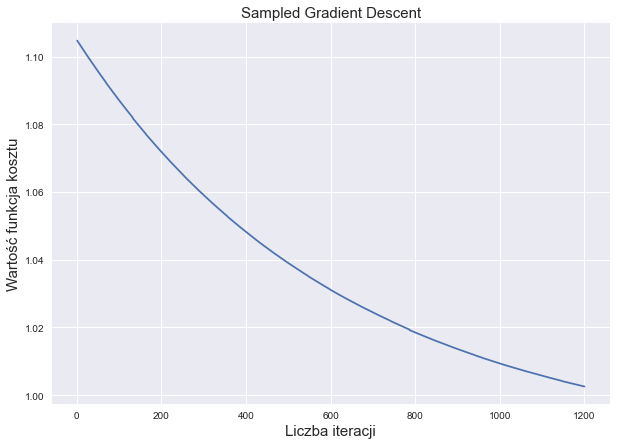

In [46]:
plot_cost_function(JOptSampl_list, 'Sampled Gradient Descent')

In [47]:
from sklearn.decomposition import PCA

In [48]:
def make_PCA(theta_list):
    pca = PCA(n_components=2)
    theta_pca = pca.fit_transform(theta_list)
    return theta_pca

In [49]:
thetaOpt_pca = make_PCA(thetaOpt_list)
thetaOptSGD_pca = make_PCA(thetaOptSGD_list)
thetaOptSampl_pca = make_PCA(thetaOptSampl_list)

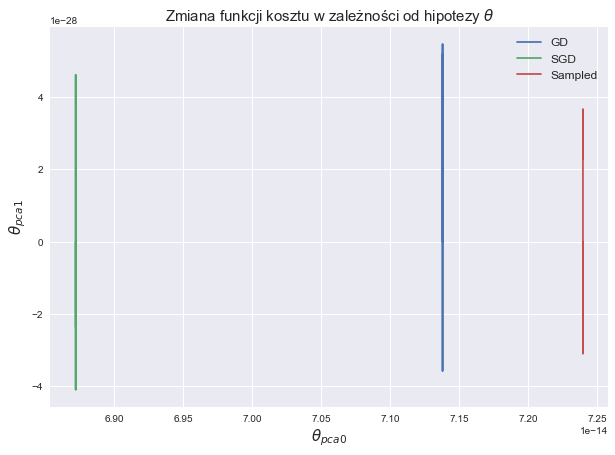

In [50]:
plt.plot(thetaOpt_pca[:,0], thetaOpt_pca[:,1], '-', label='GD')
plt.plot(thetaOptSGD_pca[:,0], thetaOptSGD_pca[:,1], '-', label='SGD')
plt.plot(thetaOptSampl_pca[:,0], thetaOptSampl_pca[:,1], '-', label='Sampled')
plt.title('Zmiana funkcji kosztu w zależności od hipotezy $\\theta$', size=15)
plt.xlabel('$\\theta_{pca0}$', size=15)
plt.ylabel('$\\theta_{pca1}$', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.legend(loc='best', prop={'size': 12})
plt.show()

Poniżej wygenerowano wykresy zależności czasu dla poszczególnych algorytmów:

In [51]:
methods_names = ['GD', 'SGD', 'Sampled']

In [52]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

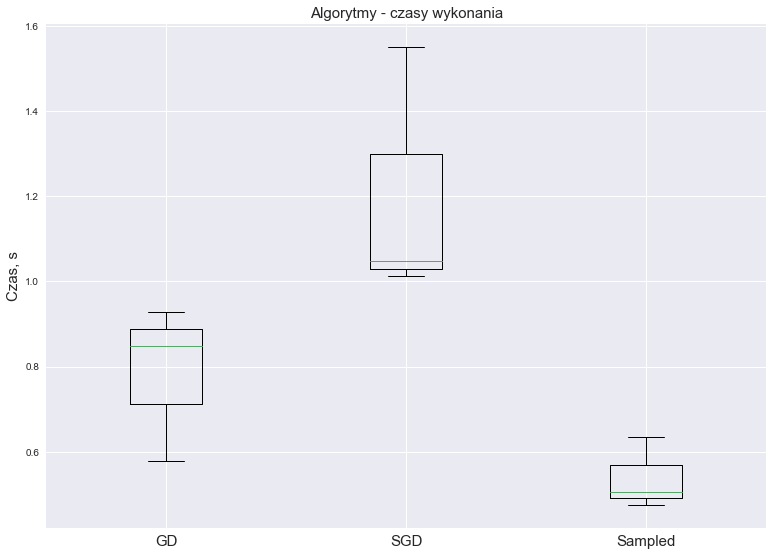

In [53]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorytmy - czasy wykonania', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Czas, s', size=15)
plt.show()

In [54]:
print(f'Metoda SGD była ok. {time_SGD.best/time_GD.best:.2f}-krotnie wolniejsza od GD i {time_SGD.best/time_Sampl.best:.2f}-krotnie wolniejsza od Sampled GD.')
print(f'Metoda GD była ok. {time_GD.best/time_Sampl.best:.2f}-krotnie wolniejsza od Sampled GD')

Metoda SGD była ok. 1.75-krotnie wolniejsza od GD i 2.13-krotnie wolniejsza od Sampled GD.
Metoda GD była ok. 1.22-krotnie wolniejsza od Sampled GD


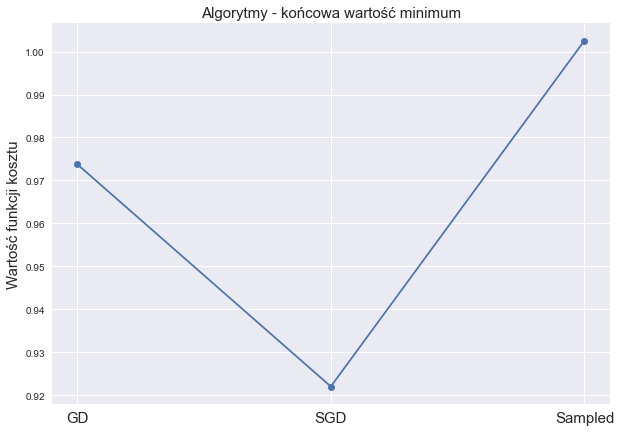

In [55]:
plt.plot([JOpt, JOptSGD, JOptSampl], '-o')
plt.title('Algorytmy - końcowa wartość minimum', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Wartość funkcji kosztu', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [56]:
print(f'Dokładność metody SGD była ok. {accuracy_SGD/accuracy_GD:.5f}-krotnie mniejsza od GD i {accuracy_SGD/accuracy_Sampl:.5f}-krotnie mniejsza od Sampled GD.')
print('Jak można zauważyć różnice były niewielkie.')

Dokładność metody SGD była ok. 1.00000-krotnie mniejsza od GD i 1.00062-krotnie mniejsza od Sampled GD.
Jak można zauważyć różnice były niewielkie.


## Wnioski:
* Metoda SGD okazała się był metodą kilkukrotnie wolniejszą od GD i Sampled GD.
* Metoda SGD okazała się był metodą niewiele dokładniejszą od GD i Sampled GD.
* Metoda Sampled GD okazała się był metodą najszybszą i najdokładniejszą.
* Zbiór danych nie został dobrze przygotowany przez co trudne było uzyskanie dokładności na poziomie ok. 90%.
* Proces szukania rozwiązania u metody SGD charakteryzuje się duża zmiennością zwracanych rozwiązań.

## Referencje:

[1] A. Ng, "CS229. Lecture notes. Supervised learning", 2012, [na:] https://web.archive.org/web/20180618211933/http://cs229.stanford.edu/notes/cs229-notes1.pdf, [dostęp:] 21.01.2023.  
[2] A. Pant, "Introduction to Logistic Regression", 2019, [na:] https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148, [dostęp:] 24.01.2023.  
[3] https://stackoverflow.com/a/29863846, [dostęp:] 21.01.2023.  